# Imports and data prep

In [1]:
%%capture
# installing and loading all needed modules

#!pip install pytorch-forecasting
#!pip install pytorch-forecasting[mqf2]
#!pip install wget
#!pip install pyunpack
#!pip install optuna

import sys
import optuna
import wget
import os
import pandas as pd
import numpy as np
import torch
import os.path
import pytorch_lightning as pl
import pickle
import tensorflow as tf
import tensorboard as tb

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.data.examples import get_stallion_data
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from tensorboard import notebook
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from pyunpack import Archive

# run to prevent compatibilty issues with tensorflow/tensorboard/pytorch
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

#from google.colab import drive
#drive.mount('/content/drive')

from dataloading_helpers import electricity_dataloader #,retail_dataloader, walmart_dataloader, stocks_dataloader
from config import *

In [36]:
#log_folder = '/content/drive/MyDrive/data/electricity/lightning_logs/version_0'

#writer = SummaryWriter(log_folder)
#%tensorboard --logdir=log_folder
#%reload_ext tensorboard
#%reload_ext tensorboard
#%tensorboard --logdir=log_folder




False

# Training

In [2]:
electricity_datasets = electricity_dataloader.create_timeseries_electricity()

In [3]:
electricity_datasets

{'training_dataset': TimeSeriesDataSet[length=2197703](
 	time_idx='time_idx',
 	target='power_usage',
 	group_ids=['categorical_id', 'id'],
 	weight=None,
 	max_encoder_length=168,
 	min_encoder_length=84,
 	min_prediction_idx=26304,
 	min_prediction_length=1,
 	max_prediction_length=24,
 	static_categoricals=['categorical_id', 'id'],
 	static_reals=['power_usage_center', 'power_usage_scale'],
 	time_varying_known_categoricals=['categorical_day_of_week', 'categorical_hour', 'month'],
 	time_varying_known_reals=['time_idx', 'hours_from_start', 'days_from_start', 'relative_time_idx'],
 	time_varying_unknown_categoricals=[],
 	time_varying_unknown_reals=['power_usage'],
 	variable_groups={},
 	constant_fill_strategy={},
 	allow_missing_timesteps=False,
 	lags={},
 	add_relative_time_idx=True,
 	add_target_scales=True,
 	add_encoder_length=False,
 	target_normalizer=GroupNormalizer(
 	method='standard',
 	groups=['categorical_id', 'id'],
 	center=True,
 	scale_by_group=False,
 	transforma

In [ ]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
#logger = TensorBoardLogger("/content/drive/MyDrive/data/electricity")  # logging results to a tensorboard



# depending on data ued choose directory

model_dir = CONFIG_DICT["models"]["electricity"]

trainer = pl.Trainer(
    default_root_dir=model_dir,
    max_epochs=5,
    accelerator='gpu',
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    #logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    electricity_datasets["training_dataset"],
    learning_rate=0.01,
    hidden_size=32,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")


# fit network
trainer.fit(
    tft,
    train_dataloaders=electricity_datasets["train_dataloader"],
    val_dataloaders=electricity_datasets["val_dataloader"],
)

INFO:lightning_lite.utilities.seed:Global seed set to 42
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.util

Number of parameters in network: 101.0k


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
'''
still needs implementation, look here for error:
https://stackoverflow.com/questions/74157157/pytorch-lightning-got-an-unexpected-keyword-argument-weights-summary


needed to implement hyper optimization of QuantileLoss():
from torchmetrics.utilities import check_forward_full_state_property
check_forward_full_state_property


Parameter range used in Google paper:

state_size = [10, 20, 40, 80, 160, 240, 320]
dropout_rate =  [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9]
minibatch_size = [64, 128, 256]
learning_rate = [0.0001, 0.001, 0.01]
ma_gradient_norm = [0.01, 1.0, 100.0]
num_heads = [1, 2, 3, 4]

'''

# create study
study = optimize_hyperparameters(
    electricity_datasets['train_dataloader'],
    electricity_datasets["val_dataloader"],
    model_path="hyper_tuning",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(10, 320),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

KeyError: ignored

In [ ]:
# save best model
#torch.save(model, 'model.pth')
print(trainer.checkpoint_callback.best_model_path)

/content/drive/MyDrive/data/electricity/lightning_logs/version_1/checkpoints/epoch=4-step=250.ckpt


In [ ]:
def evaluate_model(dataset_dict):
# calcualte mean absolute error on validation set from best model
  actuals = torch.cat([y[0] for x, y in iter(dataset_dict["train_dataloader"])])
  predictions = best_tft.predict(dataset_dict["val_dataloader"])
  print("Best model MAE: ",(actuals - predictions).abs().mean().item())


  # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
  actuals = torch.cat([y for x, (y, weight) in iter(dataset_dict["train_dataloader"])])
  baseline_predictions = Baseline().predict(dataset_dict["val_dataloader"])
  print("Baseline MAE: ",(actuals - baseline_predictions).abs().mean().item(), "\n\n")

  # raw predictions are a dictionary from which all kind of information including quantiles can be extracted
  print("Plotting attention, actuals and predictions:\n")
  raw_predictions, x = best_tft.predict(dataset_dict["val_dataloader"], mode="raw", return_x=True)

  for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path, )
evaluate_model(electricity_datasets)

KeyboardInterrupt: ignored

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(electricity_datasets["train_dataloader"])])
predictions = best_tft.predict(electricity_datasets["val_dataloader"])
print("Best model MAE: ",(actuals - predictions).abs().mean().item())


# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(electricity_datasets["train_dataloader"])])
baseline_predictions = Baseline().predict(electricity_datasets["val_dataloader"])
print("Baseline MAE: ",(actuals - baseline_predictions).abs().mean().item(), "\n\n")

  # raw predictions are a dictionary from which all kind of information including quantiles can be extracted
print("Plotting attention, actuals and predictions:\n")
raw_predictions, x = best_tft.predict(electricity_datasets["val_dataloader"], mode="raw", return_x=True)

for idx in range(5):  # plot 10 examples
  best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

KeyboardInterrupt: ignored

In [ ]:
# not working properly

output = best_tft.interpret_output(raw_predictions)
for idx in range(10):
  best_tft.plot_interpretation(output)

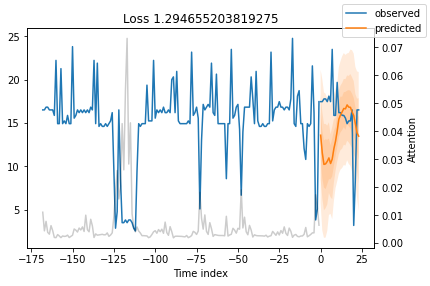

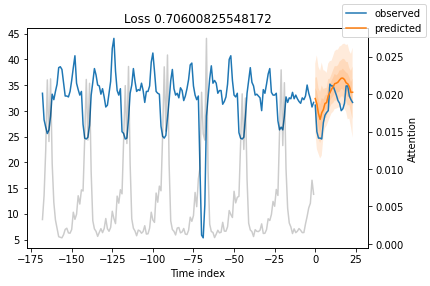

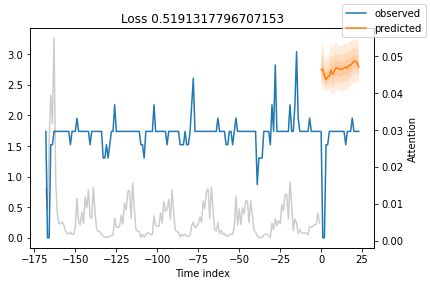

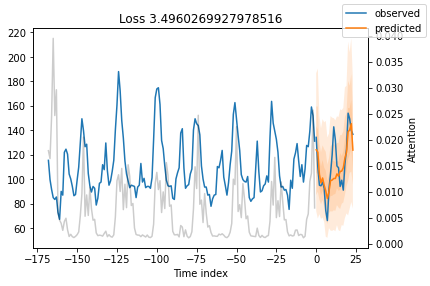

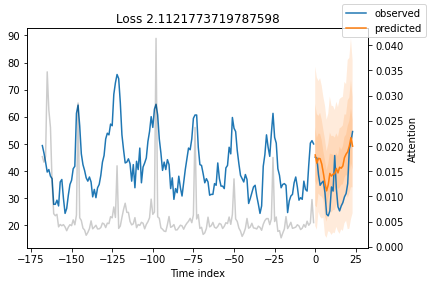

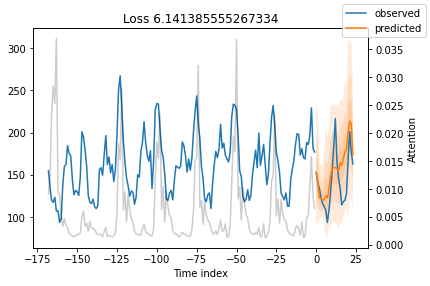

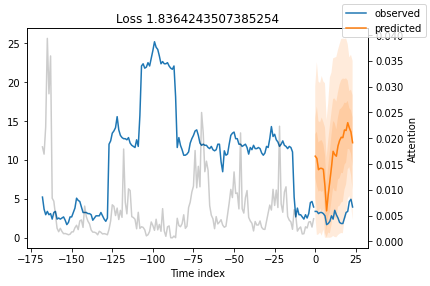

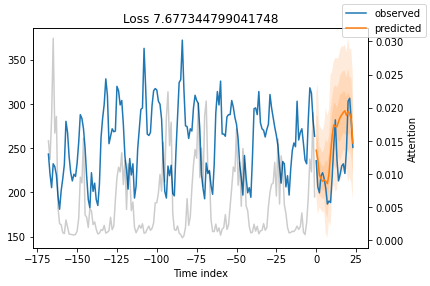

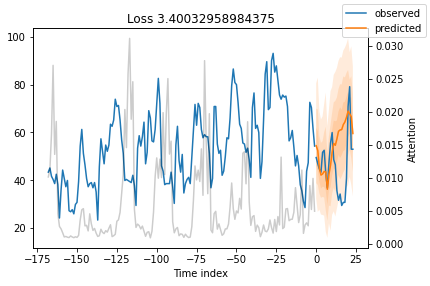

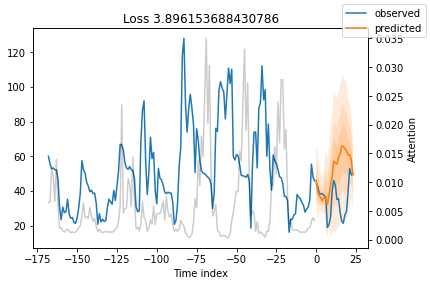

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x270 with 1 Axes>,
 'decoder_variables': <Figure size 504x270 with 1 Axes>}

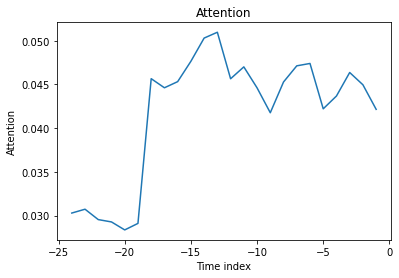

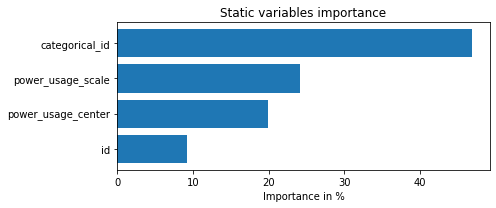

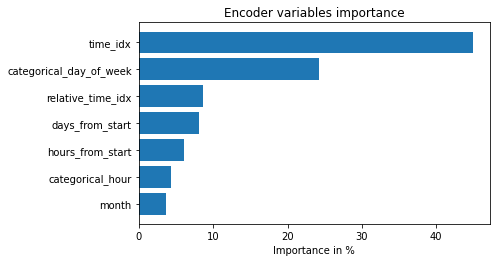

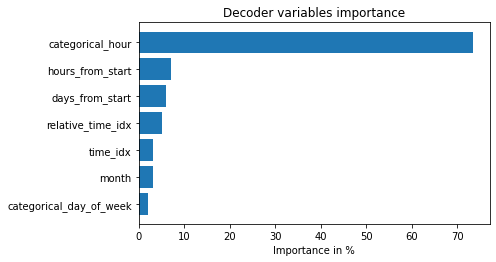

In [ ]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)